In [2]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")
import torch
import numpy as np
import time

import defmod as dm
import defmod.multimodule_usefulfunctions as mm 
import matplotlib.pyplot as plt
import defmod.hamiltonian_multishape as hamiltonian
import defmod.model_graddesc as model
import defmod.save_results as results
import defmod.optimize as optimize


torch.set_default_tensor_type(torch.DoubleTensor)

In [3]:
nb_pts1 = 20
nb_pts2 = 10
dim = 2

o1 = torch.tensor([0.,-1.])
o2 = torch.tensor([4.,3.])
origin = [o1,o2]
r1 = 2
r2 = 1
radius = [r1, r2]
nb_pts = [nb_pts1, nb_pts2]
source = mm.multipleCircles(origin, radius, nb_pts)

origin_target = [[0.,2.], [4.,-1.]]

target = mm.multipleCircles(origin_target, radius, nb_pts)


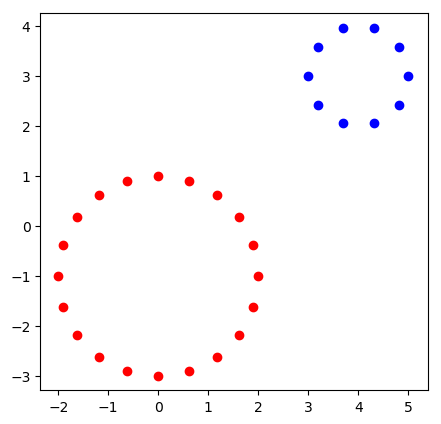

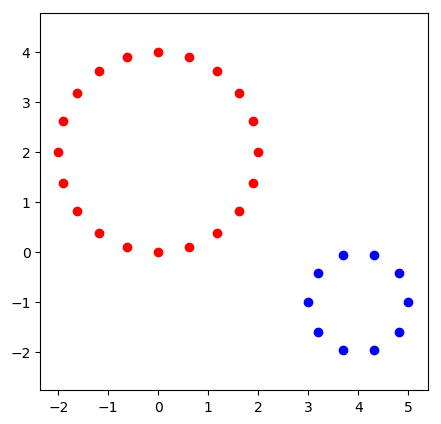

In [4]:
figsize = (5,5)
dpi = 100

fig_source = plt.figure(figsize=figsize, dpi=100)
plt.scatter(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), c='red')
plt.scatter(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), c='blue')
plt.axis('equal')

fig_target = plt.figure(figsize=figsize, dpi=100)
plt.scatter(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), c='red')
plt.scatter(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), c='blue')

plt.axis('equal')
plt.show()

In [5]:
# Defining the deformation modules
sigma1 = 20
manifold1 = dm.manifold.Landmarks(dim, nb_pts1, gd=source[0].view(-1))
trans1 = dm.deformationmodules.GlobalTranslation(manifold1, sigma1)
#trans1 = dm.deformationmodules.Translations(dm.manifold.Landmarks(2,1,gd=origin[0].view(-1).requires_grad_()), sigma1)
#trans1 = dm.deformationmodules.Translations(manifold1, 5)

silent1 = dm.deformationmodules.SilentPoints(manifold1.copy())

mod1 = dm.deformationmodules.CompoundModule([silent1, trans1])

sigma2 = 20
manifold2 = dm.manifold.Landmarks(dim, nb_pts2, gd=source[1].view(-1))
trans2 = dm.deformationmodules.GlobalTranslation(manifold2, sigma2)
silent2 = dm.deformationmodules.SilentPoints(manifold2.copy())

mod2 = dm.deformationmodules.CompoundModule([silent2, trans2])

module_list = [mod1, mod2]
sigma_bg = 0.5
modules = dm.multishape.MultiShapeModule(module_list, sigma_bg)

In [6]:
constr_Id = dm.constraints.Identity_Silent()
H = hamiltonian.Hamiltonian_multi(modules, constr_Id)

In [7]:
# set parameters
reg_param = 10**-3

gd0_tensor = torch.cat(H.module.manifold.unroll_gd(),0).requires_grad_().view(-1)
mom0_tensor = torch.zeros(gd0_tensor.shape).requires_grad_().view(-1)
gd0_tensor.retain_grad()
mom0_tensor.retain_grad()
    
from defmod.attachement import L2NormAttachement
def attach(modules, target):
    return sum([L2NormAttachement()( modules.module_list[i][0].manifold.gd, target[i]) for i in range(len(target))])
    
E = model.EnergyFunctional(modules, H, constr_Id, source, target, dim, reg_param, attach=attach)

X = [gd0_tensor, mom0_tensor]

In [8]:
import defmod.optimize as optimize

In [9]:
tic=time.time()
X[1], iter_states = optimize.BFGS(E, X, disp=True)(maxiter=1000)
toc=time.time()

../defmod/multishape.py:208: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  lambda_qp,_ = torch.gesv(B, A)


cost: 0.0 attach: 26.06551850567226
cost: 0.0 attach: 26.06551850567226
cost: 0.00306252765227924 attach: 22.260496519432866
cost: 0.00306252765227924 attach: 22.260496519432866
cost: 0.028276279821158046 attach: 14.573232562258827
cost: 0.028276279821158046 attach: 14.573232562258827
cost: 0.39620370339676175 attach: 16.62074037774022
cost: 0.39620370339676175 attach: 16.62074037774022
cost: 0.2540923214252161 attach: 12.17061121348989
cost: 0.2540923214252161 attach: 12.17061121348989
cost: 0.1123086343122945 attach: 4.254456905482184
cost: 0.1123086343122945 attach: 4.254456905482184
cost: 0.12510895807113348 attach: 7.763774341389439
cost: 0.12510895807113348 attach: 7.763774341389439
cost: 0.11241922748438071 attach: 3.9249519258129744
cost: 0.11241922748438071 attach: 3.9249519258129744
cost: 0.12163187128598832 attach: 3.4084797997847667
cost: 0.12163187128598832 attach: 3.4084797997847667
cost: 0.1352043110663577 attach: 2.52093691202941
cost: 0.1352043110663577 attach: 2.52093

cost: 0.14565767558082687 attach: 1.831351127818401e-08
cost: 0.14565767558421555 attach: 1.3297692386168697e-08
cost: 0.14565767558421555 attach: 1.3297692386168697e-08
cost: 0.14565767559641507 attach: 1.570359241844185e-08
cost: 0.14565767559641507 attach: 1.570359241844185e-08
cost: 0.14565767558831966 attach: 1.0523893574190252e-08
cost: 0.14565767558831966 attach: 1.0523893574190252e-08
cost: 0.1456576756275035 attach: 1.215642758151562e-08
cost: 0.1456576756275035 attach: 1.215642758151562e-08
cost: 0.1456576755988633 attach: 9.7342250124691e-09
cost: 0.1456576755988633 attach: 9.7342250124691e-09
cost: 0.14565767561481666 attach: 8.162396943034476e-09
cost: 0.14565767561481666 attach: 8.162396943034476e-09
cost: 0.1456576756786299 attach: 2.829409623482634e-09
cost: 0.1456576756786299 attach: 2.829409623482634e-09
cost: 0.14565767578764882 attach: 1.340626642350013e-08
cost: 0.14565767578764882 attach: 1.340626642350013e-08
cost: 0.14565767569772853 attach: 1.6684908830134038e-

cost: 0.14565767567852259 attach: 6.283772254479252e-15
cost: 0.14565767567852259 attach: 6.283772254479252e-15
cost: 0.14565767567852259 attach: 6.283772254479252e-15
cost: 0.14565767567852259 attach: 6.283772254479252e-15
cost: 0.14565767567852259 attach: 6.283772254479252e-15
cost: 0.14565767567852259 attach: 6.283772254479252e-15
cost: 0.14565767567852259 attach: 6.283772254479252e-15
cost: 0.14565767567852259 attach: 6.283772254479252e-15
cost: 0.14565767567852259 attach: 6.283772254479252e-15
cost: 0.14565767567852259 attach: 6.283772254479252e-15
cost: 0.14565767567852259 attach: 6.283772254479252e-15
cost: 0.14565767567852259 attach: 6.283772254479252e-15
cost: 0.14565767567852259 attach: 6.283772254479252e-15
cost: 0.14565767567852259 attach: 8.439108878433339e-15
cost: 0.14565767567852259 attach: 8.439108878433339e-15
cost: 0.14565767567852259 attach: 6.283772254479252e-15
cost: 0.14565767567852259 attach: 6.283772254479252e-15
cost: 0.14565767567852259 attach: 6.283772254479

../defmod/multishape.py:208: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  lambda_qp,_ = torch.gesv(B, A)


cost: 0.14565767567852264 attach: 1.3464810284455539e-14
cost: 0.1456576756785226 attach: 1.062482116905785e-14
cost: 0.14565767567852264 attach: 8.146377722140867e-15
cost: 0.14565767567852259 attach: 7.693217454381961e-15
cost: 0.1456576756785226 attach: 8.226082429728364e-15
cost: 0.14565767567852264 attach: 6.5272511002899185e-15
cost: 0.14565767567852264 attach: 7.388427149647972e-15
cost: 0.1456576756785226 attach: 7.416243408079697e-15
cost: 0.14565767567852264 attach: 7.043233786471581e-15
cost: 0.1456576756785226 attach: 6.7447013462007014e-15
cost: 0.14565767567852259 attach: 6.705413842640748e-15
cost: 0.14565767567852259 attach: 6.489023794952543e-15
         Current function value: 0.145658
         Iterations: 80
         Function evaluations: 193
         Gradient evaluations: 181


In [10]:
import defmod.save_res as results


In [11]:
toc-tic

286.9203498363495

In [14]:
H.module.manifold.fill_gd(X[0])
H.module.manifold.fill_cotan(X[1])
H.geodesic_controls()
print(torch.norm(constr_Id(H.module)))
save = results.Save_Results_MultiShape(H, source, target, E, time=toc-tic, iter_states=iter_states)

../defmod/multishape.py:208: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  lambda_qp,_ = torch.gesv(B, A)


tensor(2.2622e-14, grad_fn=<NormBackward0>)


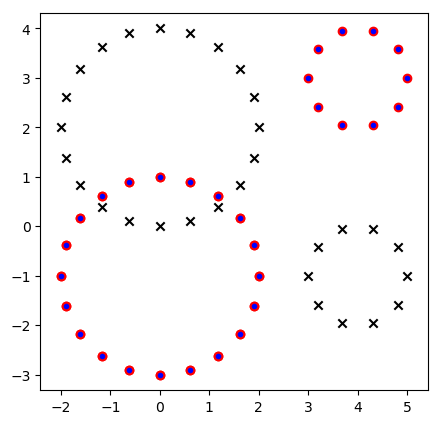

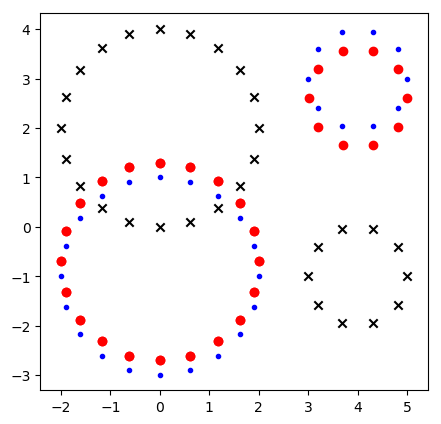

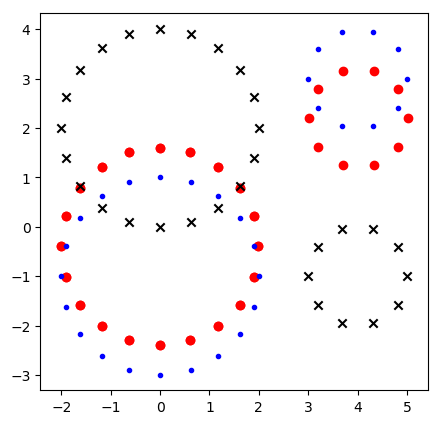

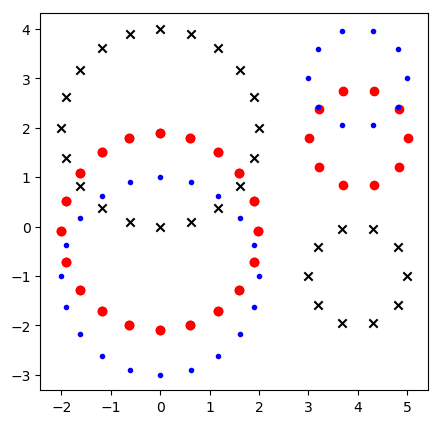

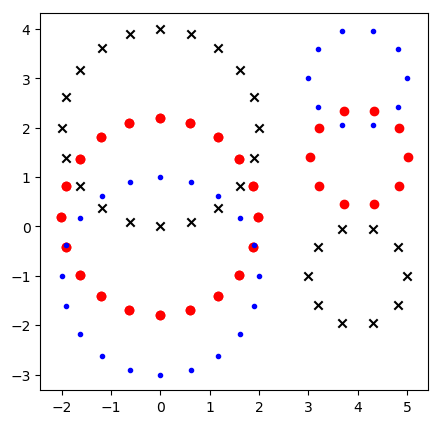

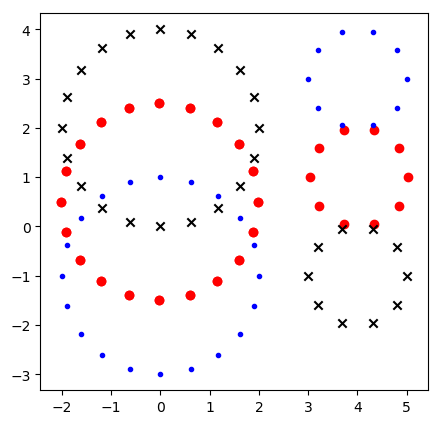

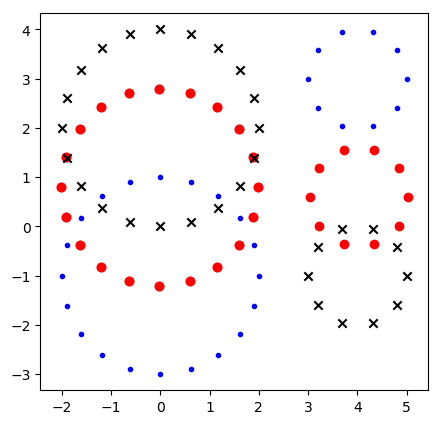

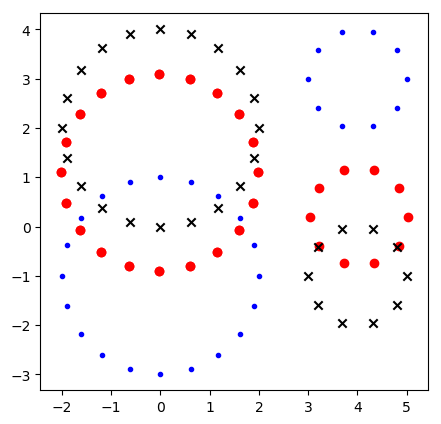

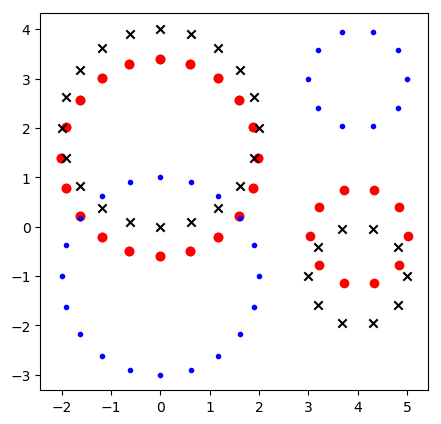

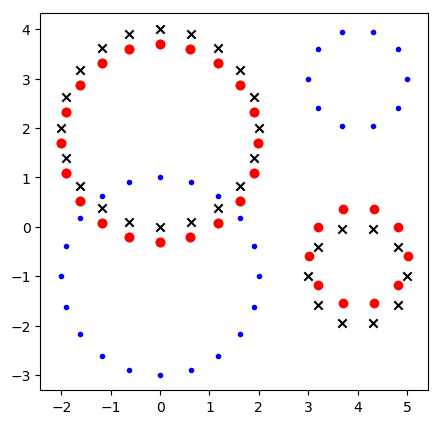

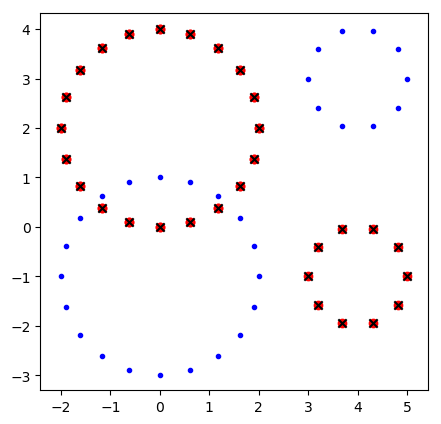

In [20]:
xlim = [-5, 10]
ylim = [-5,5]
d = [0.2, 0.2]
_ = save.gridpoints(xlim, ylim, d)

fig_states = save.fig_states(show=True, plot_gd = ['scatter', 'scatter', None, None])


In [1]:
fig_grid1, fig_grid2, fig_grid_bg, fig_multigrid = save.fig_grid(True)

NameError: name 'save' is not defined

In [23]:
save.save('../results/circles_translation/MultiShapeDefmod/', plot_gd = ['scatter', 'scatter', None, None])

plt.close('all')

../defmod/multishape_silentpoints.py:221: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  lambda_qp,_ = torch.gesv(B, A)


In [24]:
## LDDMM Module  -- sigma = sigma_bg

man_compound = dm.manifold.Landmarks(2, manifold1.nb_pts + manifold2.nb_pts, gd = torch.cat(source).view(-1))
module_LDDMM = dm.deformationmodules.CompoundModule([dm.deformationmodules.Translations(man_compound, sigma=0.5)])
H_LDDMM = dm.hamiltonian.Hamiltonian([module_LDDMM])

attach = dm.attachement.L2NormAttachement()
Energy_LDDMM = model.EnergyFunctional_unconstrained(module_LDDMM, H_LDDMM, [torch.cat(source)], [torch.cat(target)], dim=2, gamma=reg_param, attach=attach)
gd0 = torch.cat(module_LDDMM.manifold.unroll_gd())
mom0 = torch.cat(module_LDDMM.manifold.unroll_cotan())
X_LDDMM = [gd0, mom0]

X_LDDMM[1] = dm.optimize.BFGS(Energy_LDDMM, X_LDDMM, disp=True)(maxiter=250)

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


cost: 0.0 attach: 18.439088914585774
cost: 0.0 attach: 18.439088914585774
cost: 0.0010403282653804555 attach: 16.394755981693013
cost: 0.0010403282653804555 attach: 16.394755981693013
cost: 0.0260082066345114 attach: 9.868049788563592
cost: 0.0260082066345114 attach: 9.868049788563592
cost: 0.1790366818355769 attach: 13.479408765363049
cost: 0.1790366818355769 attach: 13.479408765363049
cost: 0.06340548142253857 attach: 7.440644358253178
cost: 0.06340548142253857 attach: 7.440644358253178
cost: 0.07430332946911708 attach: 6.537854222476336
cost: 0.07430332946911708 attach: 6.537854222476336
cost: 0.07078181957724516 attach: 5.407742440457253
cost: 0.07078181957724516 attach: 5.407742440457253
cost: 0.06034766008187499 attach: 4.456216929966611
cost: 0.06034766008187499 attach: 4.456216929966611
cost: 0.05923034266397664 attach: 7.521492025599624
cost: 0.05923034266397664 attach: 7.521492025599624
cost: 0.05889556178199467 attach: 4.072554407491576
cost: 0.05889556178199467 attach: 4.07

cost: 0.06909763678252173 attach: 0.8555623753848811
cost: 0.06909763678252173 attach: 0.8555623753848811
cost: 0.06837398271129767 attach: 0.8454828232593693
cost: 0.06837398271129767 attach: 0.8454828232593693
cost: 0.06710976665942474 attach: 0.8356988122700925
cost: 0.06710976665942474 attach: 0.8356988122700925
cost: 0.06668458592209221 attach: 0.8201422267539324
cost: 0.06668458592209221 attach: 0.8201422267539324
cost: 0.06559243516392152 attach: 0.8028380404527234
cost: 0.06559243516392152 attach: 0.8028380404527234
cost: 0.06388882240844883 attach: 0.8024461484688137
cost: 0.06388882240844883 attach: 0.8024461484688137
cost: 0.0648325381086022 attach: 0.7925684401619884
cost: 0.0648325381086022 attach: 0.7925684401619884
cost: 0.0643926549718542 attach: 0.777572835007007
cost: 0.0643926549718542 attach: 0.777572835007007
cost: 0.06327375569840825 attach: 0.7737844663178892
cost: 0.06327375569840825 attach: 0.7737844663178892
cost: 0.0638590909160817 attach: 0.7677046656865165


cost: 0.059467756916397406 attach: 0.17078023434457135
cost: 0.059467756916397406 attach: 0.17078023434457135
cost: 0.05947193976059506 attach: 0.17064286707427323
cost: 0.05947193976059506 attach: 0.17064286707427323
cost: 0.0594694996824381 attach: 0.17049808204134537
cost: 0.0594694996824381 attach: 0.17049808204134537
cost: 0.05947184755292488 attach: 0.17036228438163833
cost: 0.05947184755292488 attach: 0.17036228438163833
cost: 0.05947483047208803 attach: 0.17020184857874282
cost: 0.05947483047208803 attach: 0.17020184857874282
cost: 0.0594959106792759 attach: 0.17005187382449735
cost: 0.0594959106792759 attach: 0.17005187382449735
cost: 0.05950088129380776 attach: 0.16994466449199935
cost: 0.05950088129380776 attach: 0.16994466449199935
cost: 0.05952376361174368 attach: 0.16980386562333827
cost: 0.05952376361174368 attach: 0.16980386562333827
cost: 0.05953306009346605 attach: 0.16967981488209735
cost: 0.05953306009346605 attach: 0.16967981488209735
cost: 0.05955481774145166 atta

In [25]:
H_LDDMM.module.manifold.fill_gd(X_LDDMM[0])
H_LDDMM.module.manifold.fill_cotan(X_LDDMM[1])
H_LDDMM.geodesic_controls()
save = results.Save_Results_SingleShape(H_LDDMM, source, target)

../defmod/deformationmodules.py:114: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  controls, _ =  torch.gesv(vs(self.manifold.gd.view(-1, self.manifold.dim)), K_q)


TypeError: __init__() missing 1 required positional argument: 'Energy'

In [ ]:
xlim = [-5, 10]
ylim = [-5,5]
d = [0.2, 0.2]
_ = save.gridpoints(xlim, ylim, d)
save.fig_grid(True)

#save.save('../results/circles_translation/LDDMM_sigma0.5/')
#plt.close('all')

In [ ]:
## LDDMM Module  -- medium sigma 

man_compound = dm.manifold.Landmarks(2, manifold1.nb_pts + manifold2.nb_pts, gd = torch.cat(source).view(-1))
module_LDDMM = dm.deformationmodules.CompoundModule([dm.deformationmodules.Translations(man_compound, sigma=5)])
H_LDDMM = dm.hamiltonian.Hamiltonian([module_LDDMM])

attach = dm.attachement.L2NormAttachement()
Energy_LDDMM = model.EnergyFunctional_unconstrained(module_LDDMM, H_LDDMM, [torch.cat(source)], [torch.cat(target)], dim=2, gamma=reg_param, attach=attach)
gd0 = torch.cat(module_LDDMM.manifold.unroll_gd())
mom0 = torch.cat(module_LDDMM.manifold.unroll_cotan())
X_LDDMM = [gd0, mom0]

X_LDDMM[1] = dm.optimize.BFGS(Energy_LDDMM, X_LDDMM, disp=True)(maxiter=250)

H_LDDMM.module.manifold.fill_gd(X_LDDMM[0])
H_LDDMM.module.manifold.fill_cotan(X_LDDMM[1])
H_LDDMM.geodesic_controls()
save = results.Save_Results_SingleShape(H_LDDMM, source, target)

xlim = [-5, 10]
ylim = [-5,5]
d = [0.2, 0.2]
_ = save.gridpoints(xlim, ylim, d)
save.fig_grid(True)

save.save('../results/circles_translation/LDDMM_sigma5/')
plt.close('all')

In [ ]:
## LDDMM Module  -- Big sigma 

man_compound = dm.manifold.Landmarks(2, manifold1.nb_pts + manifold2.nb_pts, gd = torch.cat(source).view(-1))
module_LDDMM = dm.deformationmodules.CompoundModule([dm.deformationmodules.Translations(man_compound, sigma=20)])
H_LDDMM = dm.hamiltonian.Hamiltonian([module_LDDMM])

attach = dm.attachement.L2NormAttachement()
Energy_LDDMM = model.EnergyFunctional_unconstrained(module_LDDMM, H_LDDMM, [torch.cat(source)], [torch.cat(target)], dim=2, gamma=reg_param, attach=attach)
gd0 = torch.cat(module_LDDMM.manifold.unroll_gd())
mom0 = torch.cat(module_LDDMM.manifold.unroll_cotan())
X_LDDMM = [gd0, mom0]

In [ ]:
X_LDDMM[1] = dm.optimize.BFGS(Energy_LDDMM, X_LDDMM, disp=True)(maxiter=250)

In [ ]:
H_LDDMM.module.manifold.fill_gd(X_LDDMM[0])
H_LDDMM.module.manifold.fill_cotan(X_LDDMM[1])
H_LDDMM.geodesic_controls()
save = results.Save_Results_SingleShape(H_LDDMM, source, target)

xlim = [-5, 10]
ylim = [-5,5]
d = [0.2, 0.2]
_ = save.gridpoints(xlim, ylim, d)
save.fig_grid(True)

save.save('../results/circles_translation/LDDMM_sigma20/')
plt.close('all')

In [ ]:
save.fig_states(True, axeslim=[-8,8, -8,8])

In [ ]:
## LDDMM Multishape Module
sigma1 = 1
manifold1 = dm.manifold.Landmarks(dim, nb_pts1, gd=source[0].view(-1))
trans1 = dm.deformationmodules.Translations(manifold1, sigma1)
silent1 = dm.deformationmodules.SilentPoints(manifold1.copy())

mod1 = dm.deformationmodules.CompoundModule([silent1, trans1])

sigma2 = 1
manifold2 = dm.manifold.Landmarks(dim, nb_pts2, gd=source[1].view(-1))
trans2 = dm.deformationmodules.Translations(manifold2, sigma2)
silent2 = dm.deformationmodules.SilentPoints(manifold2.copy())

mod2 = dm.deformationmodules.CompoundModule([silent2, trans2])

module_list = [mod1, mod2]
sigma_bg = 0.5
multi_LDDMM = dm.multishape.MultiShapeModule(module_list, sigma_bg)

constr = dm.constraints.Identity_Silent()
H_multi_LDDMM = dm.hamiltonian_multishape.Hamiltonian_multi(multi_LDDMM, constr)

In [ ]:
def attach(modules, target):
    return sum([L2NormAttachement()( modules.module_list[i][1].manifold.gd, target[i]) for i in range(len(target))])
    
Energy_multi_LDDMM = model.EnergyFunctional(multi_LDDMM, H_multi_LDDMM, constr, source, target, dim=2, gamma=reg_param, attach = attach)
gd0 = torch.cat(multi_LDDMM.manifold.unroll_gd())
mom0 = torch.cat(multi_LDDMM.manifold.unroll_cotan())
X_multi_LDDMM = [gd0, mom0]


X_multi_LDDMM[1] = dm.optimize.BFGS(Energy_multi_LDDMM, X_multi_LDDMM, disp=True)(maxiter=20)

In [ ]:
H_multi_LDDMM.module.manifold.fill_gd(X_multi_LDDMM[0])
H_multi_LDDMM.module.manifold.fill_cotan(X_multi_LDDMM[1])
H_multi_LDDMM.geodesic_controls()
print(torch.norm(constr_Id(H_multi_LDDMM.module)))
save = results.Save_Results_MultiShape(H_multi_LDDMM, source, target)

In [ ]:
xlim = [-5, 10]
ylim = [-5,5]
d = [0.2, 0.2]
_ = save.gridpoints(xlim, ylim, d)
save.fig_grid(True)

#save.save('../results/circles_translation/MultiShapeLDDMM/')
#plt.close('all')

In [ ]:
## Unconstrained Compound Module

man_compound = dm.manifold.Landmarks(2, manifold1.nb_pts + manifold2.nb_pts, gd = torch.cat(source).view(-1))
trans1_comp = dm.deformationmodules.GlobalTranslation(manifold1, sigma = 5.)
trans1_comp.fill_controls_zero()
trans2_comp = dm.deformationmodules.GlobalTranslation(manifold2, sigma = 5.)
trans2_comp.fill_controls_zero()
trans_bg = dm.deformationmodules.Translations(man_compound, sigma=0.5)

module_compound = dm.deformationmodules.CompoundModule([trans1_comp, trans2_comp, trans_bg])
H_compound = dm.hamiltonian.Hamiltonian(module_compound)

attach = dm.attachement.L2NormAttachement()
Energy_compound = model.EnergyFunctional_unconstrained(module_compound, H_compound, source, target, dim=2, gamma=reg_param, attach=attach)
gd0_c = torch.cat(module_compound.manifold.unroll_gd())
mom0_c = torch.cat(module_compound.manifold.unroll_cotan())
X_compound = [gd0_c, mom0_c]

In [ ]:
X_compound[1] = dm.optimize.BFGS(Energy_compound, X_compound, disp=True)(maxiter=20)

In [ ]:
H_compound.module.manifold.fill_gd(X_compound[0])
H_compound.module.manifold.fill_cotan(X_compound[1])
H_compound.geodesic_controls()
save = results.Save_Results_SingleShape(H_compound, source, target)

In [ ]:
xlim = [-5, 10]
ylim = [-5,5]
d = [0.2, 0.2]
_ = save.gridpoints(xlim, ylim, d)
#fig = save.fig_grid(True)

save.save('../results/circles_translation/Compound/')
plt.close('all')

In [ ]:
def test_gradcheck_Hamiltonian():
    def hamiltonian(gd, mom):
        
        h.module.manifold.fill_gd(gd)
        h.module.manifold.fill_cotan(mom)
        h.geodesic_controls()
        return h()
    
    return torch.autograd.gradcheck(hamiltonian, (gd, mom), raise_exception=True)

h = H
gd0_tensor = torch.cat(h.module.manifold.unroll_gd().copy(),0).requires_grad_().view(-1)
gd = gd0_tensor
mom = 1000*torch.rand(gd.shape)


test_gradcheck_Hamiltonian()

In [ ]:
def test_gradcheck_Hamiltonian():
    def hamiltonian(gd, mom):
        
        mod.manifold.fill_gd(gd)
        mod.manifold.fill_cotan(mom)
        #H.geodesic_controls()
        #return H()
        mod.compute_geodesic_control_from_self(mod.manifold)
        return mod.controls
    
    return torch.autograd.gradcheck(hamiltonian, (gd, mom), raise_exception=True)

mod = H.module.module_list[0].copy()

#gd0_tensor = torch.cat(mod.manifold.unroll_gd().copy(),0).requires_grad_().view(-1)
#gd = gd0_tensor
#mom = 1000*torch.rand(gd.shape)

gd = torch.cat(mod.manifold.gd).clone().requires_grad_()
mom = torch.cat(mod.manifold.cotan).clone().requires_grad_()


#test_gradcheck_Hamiltonian()

In [ ]:
# Defining the deformation modules
sigma1 = 20
manifold1 = dm.manifold.Landmarks(dim, nb_pts1, gd=source[0].view(-1))
trans1 = dm.deformationmodules.GlobalTranslation(manifold1, sigma1)
trans1.fill_controls_zero()
#trans1 = dm.deformationmodules.Translations(manifold1, sigma1)
silent1 = dm.deformationmodules.SilentPoints(manifold1.copy())
mod1 = dm.deformationmodules.CompoundModule([silent1, trans1])

sigma_scaling = 1.
a = torch.sqrt(torch.tensor(3.))
direc_scaling_pts = torch.tensor([[1., 0.], [-0.5 , 0.5* a],  [-0.5, -0.5* a]], requires_grad=True, dtype=torch.float64)
direc_scaling_vec =  torch.tensor([[1., 0.], [-0.5 , 0.5* a],  [-0.5, -0.5* a]], requires_grad=True, dtype=torch.float64)
def f(x):
    centre = x.view(1,2).repeat(3,1)
    return centre + 0.3 * sigma_scaling * direc_scaling_pts

def g(x):
    return direc_scaling_vec
scaling0 = dm.deformationmodules.ConstrainedTranslations(dm.manifold.Landmarks(2, 1, gd = torch.tensor([0.,0.]).view(-1).requires_grad_()), f, g, sigma_scaling)

man_scal = dm.manifold.Landmarks(2,1, gd=torch.tensor([0.,0.]).view(-1).requires_grad_())
scal = dm.deformationmodules.LocalScaling(man_scal, sigma=5.)
sigma2 = 20
manifold2 = dm.manifold.Landmarks(dim, nb_pts2, gd=source[1].view(-1))
trans2 = dm.deformationmodules.GlobalTranslation(manifold2, sigma2)
trans2.fill_controls_zero()
trans2 = dm.deformationmodules.Translations(manifold2, sigma2)
silent2 = dm.deformationmodules.SilentPoints(manifold2.copy())
mod2 = dm.deformationmodules.CompoundModule([silent2, trans2, scal])


module_list = [mod1, mod2]
sigma_bg = 5.
modules = dm.multishape.MultiShapeModule(module_list, sigma_bg)

constr_Id = dm.constraints.Identity_Silent()
H = hamiltonian.Hamiltonian_multi(modules, constr_Id)

In [ ]:
dty = torch.float64
gd0 = torch.tensor([-1., 0.], requires_grad=True, dtype=dty)
gd1 = torch.tensor([1., 0.], requires_grad=True, dtype=dty)

nb_pts = source[0].shape[0]
man_silent = dm.manifold.Landmarks(2, nb_pts, gd=source[0].view(-1).requires_grad_())
man_scal1 = dm.manifold.Landmarks(2,1,gd=gd0)
man_scal2 = dm.manifold.Landmarks(2,1,gd=gd1)

sigma_scaling = 1.
silent = dm.deformationmodules.SilentPoints(man_silent)
scal1 = dm.deformationmodules.LocalScaling(man_scal1, sigma = sigma_scaling)
scal2 = dm.deformationmodules.LocalScaling(man_scal2, sigma = sigma_scaling)
trans = dm.deformationmodules.Translations(dm.manifold.Landmarks(2,1,gd = torch.tensor([0.,0.]).view(-1).requires_grad_()), sigma=400, coeff=5.)

comp1 = dm.deformationmodules.CompoundModule([silent, scal1, scal2, trans])

modules = dm.multishape.MultiShapeModule([comp1], sigma_bg)
constr_Id = dm.constraints.Identity_Silent()
H = hamiltonian.Hamiltonian_multi(modules, constr_Id)

In [ ]:
def test_gradcheck():
    def fun(gd, mom):
        mod.manifold.fill_gd(gd)
        mod.manifold.fill_cotan(mom)
        mod.compute_geodesic_control_from_self(mod.manifold.copy(retain_grad=True))
        return mod.controls
    return torch.autograd.gradcheck(fun, (gd, mom), raise_exception=True)

mod = dm.deformationmodules.CompoundModule([silent1, trans1])
#h = hamiltonian.Hamiltonian_multi(dm.multishape.MultiShapeModule(modlist, sigma_bg), constr_Id)

gd = torch.cat(mod.manifold.gd.copy()).detach().requires_grad_()
mom = torch.cat(mod.manifold.cotan.copy()).detach().requires_grad_()

test_gradcheck()